# Developing scripts for data preparation

In [38]:
import xarray as xr

from pathlib import Path

from src import utils
from src.data import prepare_dataset

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

# Cluster

In [194]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 24
memory = "96GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83+gdata/oi10",
    ],
    local_directory="$PBS_JOBFS",
    # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
    header_skip=["select"],
)

In [195]:
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.78.68:8787/status,
Dashboard: http://10.6.78.68:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.78.68:35623,Workers: 0
Dashboard: http://10.6.78.68:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
PROJECT_DIR = Path("/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/")

config_path = PROJECT_DIR / "config"
save_dir = PROJECT_DIR / "data/processed"

prepare_dataset(f"{config_path}/CAFE_hist.yaml", save_dir)

/g/data/xv83/users/ds0092/software/miniconda3/envs/cafe-f6_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/cafe-f6_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/cafe-f6_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 80 times more chunks
  return self.array[key]


In [ ]:
ds = "CAFE_hist"
var = "ohc300"
test = xr.open_zarr(PROJECT_DIR / f"data/processed/{ds}.{var}.zarr")
test

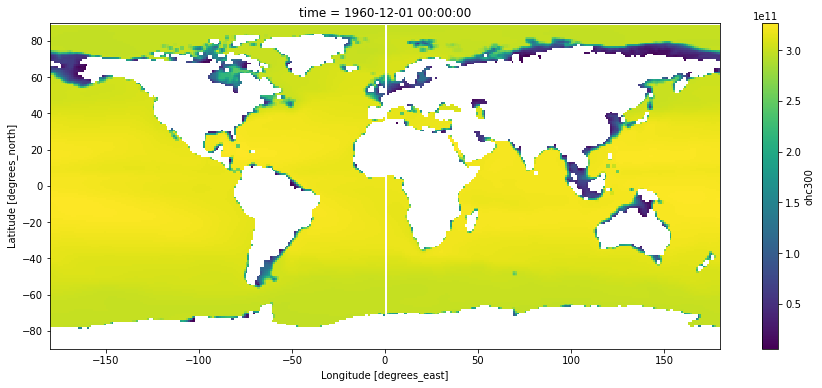

In [277]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 6))
test[var].isel(time=0).plot()

In [ ]:
def make_datasets(datasets, yaml_suffix):
    """ Process dataset according to specifications in a provided set of config files
        and save output ../processed
    """
    ds

In [140]:
def JRA55(realm, variables):
    """Open JRA55 data following specifications in JRA55.yaml"""

    cfg = _load_config("JRA55")

    if isinstance(variables, str):
        variables = [variables]

    if "rename" in cfg:
        variables = _maybe_translate_variables(variables, cfg["rename"])

    if "preprocess" in cfg:
        warnings.warn(
            "preprocess functions were provided but not used because the data does not require concatenation"
        )

    ds = xr.open_dataset(
        f"{cfg['path']}/{realm}.zarr.zip",
        engine="zarr",
        chunks={},
        use_cftime=True,
    )[variables]

    if "rename" in cfg:
        ds = _maybe_rename(ds, cfg["rename"])

    if "scale_variables" in cfg:
        ds = _normalise(ds, cfg["scale_variables"])

    if "postprocess" in cfg:
        ds = _composite_function(cfg["postprocess"])(ds)

    return ds


def HadISST(variables):
    """Open HadISST data following specifications in HadISST.yaml"""

    cfg = _load_config("HadISST")

    if isinstance(variables, str):
        variables = [variables]

    if "rename" in cfg:
        variables = _maybe_translate_variables(variables, cfg["rename"])

    if "preprocess" in cfg:
        warnings.warn(
            "preprocess functions were provided but not used because the data does not require concatenation"
        )

    ds = xr.open_dataset(
        f"{cfg['path']}/ocean_month.zarr",
        engine="zarr",
        chunks={},
        use_cftime=True,
    )[variables]
    ds = ds.where(ds > -1000)

    if "rename" in cfg:
        ds = _maybe_rename(ds, cfg["rename"])

    if "normalise" in cfg:
        ds = _normalise(ds, cfg["normalise"])

    if "postprocess" in cfg:
        ds = _composite_function(cfg["postprocess"])(ds)

    return ds


def EN422(variables):
    """Open EN.4.2.2 data following specifications in EN422.yaml"""

    cfg = _load_config("EN422")

    if isinstance(variables, str):
        variables = [variables]

    if "rename" in cfg:
        variables = _maybe_translate_variables(variables, cfg["rename"])

    if "preprocess" in cfg:
        warnings.warn(
            "preprocess functions were provided but not used because the data does not require concatenation"
        )

    ds = xr.open_mfdataset(
        f"{PATHS['EN422']}/*.nc",
        parallel=True,
        use_cftime=True,
    )[variables]

    if "rename" in cfg:
        ds = _maybe_rename(ds, cfg["rename"])

    if "normalise" in cfg:
        ds = _normalise(ds, cfg["normalise"])

    if "postprocess" in cfg:
        ds = _composite_function(cfg["postprocess"])(ds)

    return ds


def CAFEf6(realm, variables):
    """Open CAFEf6 forecast data following specifications in CAFEf6.yaml"""

    cfg = _load_config("CAFEf6")

    if isinstance(variables, str):
        variables = [variables]

    if "rename" in cfg:
        variables = _maybe_translate_variables(variables, cfg["rename"])

    if "preprocess" in cfg:
        preprocess = _composite_function(cfg["preprocess"])
    else:
        preprocess = None

    files = sorted(
        glob.glob(f"{cfg['path']}/c5-d60-pX-f6-????1101/{realm}.zarr.zip")
    )  # Skip May starts

    ds = xr.open_mfdataset(
        files,
        compat="override",
        preprocess=preprocess,
        engine="zarr",
        coords="minimal",
        parallel=True,
    )[variables]

    if "rename" in cfg:
        ds = _maybe_rename(ds, cfg["rename"])

    if "normalise" in cfg:
        ds = _normalise(ds, cfg["normalise"])

    if "postprocess" in cfg:
        ds = _composite_function(cfg["postprocess"])(ds)

    return ds


def CAFEf5(realm, variables):
    """Open CAFE-f5 forecast data following specifications in CAFEf5.yaml"""

    cfg = _load_config("CAFEf5")

    if isinstance(variables, str):
        variables = [variables]

    if "rename" in cfg:
        variables = _maybe_translate_variables(variables, cfg["rename"])

    if "preprocess" in cfg:
        warnings.warn(
            "preprocess functions were provided but not used because the data does not require concatenation"
        )

    ds = xr.open_dataset(
        f"{cfg['path']}/NOV/{realm}.zarr.zip", engine="zarr", chunks={}
    )[variables]

    # Append 2020 forecast from CAFE-f6
    cfg_f6 = _load_config("CAFEf6")

    ds_2020 = xr.open_dataset(
        f"{cfg_f6['path']}/c5-d60-pX-f6-20201101/{realm}.zarr.zip",
        engine="zarr",
        chunks={},
    )[variables]
    ds_2020 = ds_2020.isel(ensemble=range(10))
    ds_2020 = utils.convert_time_to_lead(ds_2020)

    if "rename" in cfg:
        ds = _maybe_rename(ds, cfg["rename"])
        ds_2020 = _maybe_rename(ds_2020, cfg["rename"])

    if "normalise" in cfg:
        ds = _normalise(ds, cfg["normalise"])
        ds_2020 = _normalise(ds_2020, cfg["normalise"])

    if "postprocess" in cfg:
        ds = _composite_function(cfg["postprocess"])(ds)
        ds_2020 = _composite_function(cfg["postprocess"])(ds_2020)

    return xr.concat([ds, ds_2020], dim="init")


def CAFE60v1(realm, variables):
    """Open CAFE60v1 data following specifications in CAFE60v1.yaml"""

    cfg = _load_config("CAFE60v1")

    if isinstance(variables, str):
        variables = [variables]

    if "rename" in cfg:
        variables = _maybe_translate_variables(variables, cfg["rename"])

    if "preprocess" in cfg:
        warnings.warn(
            "preprocess functions were provided but not used because the data does not require concatenation"
        )

    ds = xr.open_dataset(f"{cfg['path']}/{realm}.zarr.zip", engine="zarr", chunks={})[
        variables
    ]

    if "rename" in cfg:
        ds = _maybe_rename(ds, cfg["rename"])

    if "normalise" in cfg:
        ds = _normalise(ds, cfg["normalise"])

    if "postprocess" in cfg:
        ds = _composite_function(cfg["postprocess"])(ds)

    return ds


def CAFE_hist(realm, variables):
    """Open CAFE historical data following specifications in CAFE_hist.yaml"""

    cfg = _load_config("CAFE_hist")

    if isinstance(variables, str):
        variables = [variables]

    if "rename" in cfg:
        variables = _maybe_translate_variables(variables, cfg["rename"])

    if "preprocess" in cfg:
        warnings.warn(
            "preprocess functions were provided but not used because the data does not require concatenation"
        )

    hist = xr.open_dataset(
        f"{cfg['path']}/c5-d60-pX-hist-19601101/ZARR/{realm}.zarr.zip",
        engine="zarr",
        chunks={},
    )[variables]

    ctrl = xr.open_dataset(
        f"{cfg['path']}/c5-d60-pX-ctrl-19601101/ZARR/{realm}.zarr.zip",
        engine="zarr",
        chunks={},
    )[variables].mean("ensemble")

    if "rename" in cfg:
        hist = _maybe_rename(hist, cfg["rename"])
        ctrl = _maybe_rename(ctrl, cfg["rename"])

    if "normalise" in cfg:
        hist = _normalise(hist, cfg["normalise"])
        ctrl = _normalise(ctrl, cfg["normalise"])

    if "postprocess" in cfg:
        hist = _composite_function(cfg["postprocess"])(hist)
        ctrl = _composite_function(cfg["postprocess"])(ctrl)

    drift = ctrl.groupby("time.month").map(lambda x: x - x.mean(["time"]))
    return hist - drift

